In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from skimage.segmentation import slic
from skimage import filters

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
DMC_PALETTE = [
    ("310", "Black", 0, 0, 0),
    ("B5200", "White", 255, 255, 255),
    ("762", "Pearl Gray VL", 236, 236, 236),
    ("415", "Pearl Gray", 211, 211, 214),
    ("318", "Steel Gray LT", 171, 171, 171),
    ("414", "Steel Gray DK", 140, 140, 140),
    ("666", "Red Bright", 227, 29, 66),
    ("321", "Red", 199, 23, 55),
    ("498", "Red Dark", 167, 17, 43),
    ("817", "Coral Red VY DK", 187, 27, 43),
    ("3705", "Melon DK", 255, 85, 91),
    ("3801", "Melon VY DK", 231, 73, 103),
    ("608", "Orange Bright", 253, 93, 21),
    ("606", "Orange Red Bright", 250, 50, 3),
    ("741", "Tangerine MD", 255, 163, 0),
    ("740", "Tangerine", 255, 139, 0),
    ("444", "Yellow DK", 255, 182, 0),
    ("307", "Lemon", 253, 237, 0),
    ("973", "Canary Bright", 255, 227, 0),
    ("727", "Topaz VY LT", 255, 241, 176),
    ("703", "Chartreuse", 123, 158, 53),
    ("701", "Green LT", 79, 108, 69),
    ("700", "Green Bright", 0, 96, 47),
    ("699", "Green", 5, 101, 23),
    ("3817", "Celadon Green LT", 153, 178, 150),
    ("964", "Seagreen LT", 176, 224, 230),
    ("959", "Seagreen MD", 102, 168, 174),
    ("958", "Seagreen DK", 62, 141, 139),
    ("3843", "Electric Blue", 20, 170, 208),
    ("996", "Electric Blue MD", 0, 158, 219),
    ("995", "Electric Blue DK", 0, 123, 167),
    ("825", "Blue DK", 53, 93, 146),
    ("820", "Royal Blue VY DK", 25, 53, 123),
    ("797", "Royal Blue", 18, 56, 133),
    ("333", "Blue Violet VY DK", 92, 78, 132),
    ("791", "Cornflower Blue VY DK", 91, 79, 139),
    ("3609", "Plum UL LT", 247, 208, 229),
    ("3608", "Plum VY LT", 221, 146, 178),
    ("718", "Plum", 137, 51, 99),
    ("917", "Plum MD", 173, 35, 104),
]

# Convert to numpy array for distance calculations
dmc_colors_rgb = np.array([[r, g, b] for _, _, r, g, b in DMC_PALETTE])
dmc_codes = [code for code, _, _, _, _ in DMC_PALETTE]
dmc_names = [name for _, name, _, _, _ in DMC_PALETTE]

print(f"✅ Loaded {len(DMC_PALETTE)} DMC thread colors")


✅ Loaded 40 DMC thread colors


In [3]:
def rgb_to_lab(rgb):
    """Convert RGB to Lab color space for better color matching"""
    # RGB should be in range 0-255
    rgb_normalized = rgb.astype(np.float32) / 255.0
    lab = cv2.cvtColor(rgb_normalized.reshape(1, 1, 3), cv2.COLOR_RGB2LAB)
    return lab.reshape(3)

def lab_to_rgb(lab):
    """Convert Lab back to RGB"""
    rgb = cv2.cvtColor(lab.reshape(1, 1, 3).astype(np.float32), cv2.COLOR_LAB2RGB)
    return (rgb.reshape(3) * 255).astype(np.uint8)

def delta_e(lab1, lab2):
    """Calculate color difference using Delta E (CIE76)"""
    return np.sqrt(np.sum((lab1 - lab2) ** 2))

def find_closest_dmc(rgb_color):
    """Find the closest DMC thread color to given RGB"""
    lab_color = rgb_to_lab(rgb_color)
    dmc_lab = np.array([rgb_to_lab(dmc_colors_rgb[i]) for i in range(len(dmc_colors_rgb))])
    
    distances = np.array([delta_e(lab_color, dmc_lab[i]) for i in range(len(dmc_lab))])
    closest_idx = np.argmin(distances)
    
    return closest_idx, dmc_codes[closest_idx], dmc_names[closest_idx]

print("✅ Helper functions defined")


✅ Helper functions defined


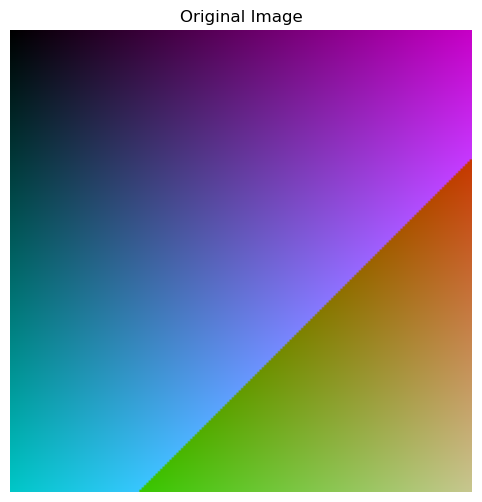

✅ Image loaded: (200, 200)


In [4]:
img = Image.new('RGB', (200, 200))
pixels = img.load()
for i in range(200):
    for j in range(200):
        pixels[i, j] = (i % 255, j % 255, (i+j) % 255)

# Display original
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

print(f"✅ Image loaded: {img.size}")


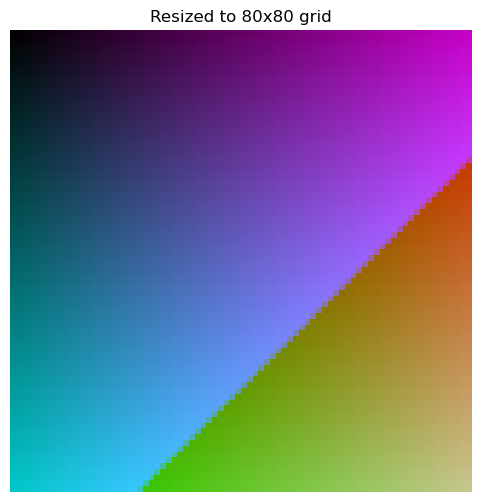

✅ Resized to 80x80


In [5]:
PATTERN_WIDTH = 80
PATTERN_HEIGHT = 80

# Resize image to pattern size
img_resized = img.resize((PATTERN_WIDTH, PATTERN_HEIGHT), Image.Resampling.LANCZOS)

plt.figure(figsize=(8, 6))
plt.imshow(img_resized)
plt.title(f"Resized to {PATTERN_WIDTH}x{PATTERN_HEIGHT} grid")
plt.axis('off')
plt.show()

print(f"✅ Resized to {PATTERN_WIDTH}x{PATTERN_HEIGHT}")

Reducing to 12 colors...


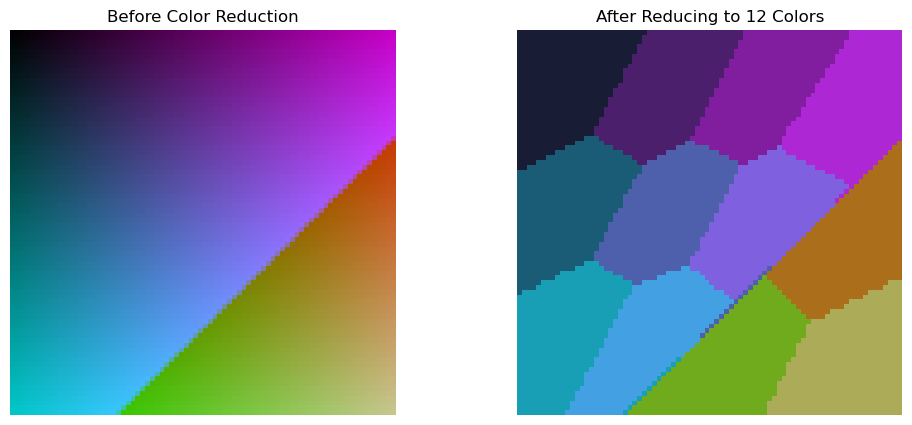

✅ Reduced to 12 colors


In [6]:
N_COLORS = 12  # Start with 12, adjust based on results

# Convert to numpy array
img_array = np.array(img_resized)
pixels = img_array.reshape(-1, 3)

# Apply k-means clustering
print(f"Reducing to {N_COLORS} colors...")
kmeans = KMeans(n_clusters=N_COLORS, random_state=42, n_init=10)
kmeans.fit(pixels)

# Get clustered image
labels = kmeans.labels_
centers = kmeans.cluster_centers_.astype(int)
clustered_img = centers[labels].reshape(img_array.shape)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title("Before Color Reduction")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clustered_img)
plt.title(f"After Reducing to {N_COLORS} Colors")
plt.axis('off')
plt.show()

print(f"✅ Reduced to {N_COLORS} colors")



Color Mapping:
------------------------------------------------------------
Cluster 0: RGB(np.int64(171), np.int64(111), np.int64(28)) → DMC 740 (Tangerine)
Cluster 1: RGB(np.int64(24), np.int64(158), np.int64(181)) → DMC 3843 (Electric Blue)
Cluster 2: RGB(np.int64(76), np.int64(31), np.int64(108)) → DMC 820 (Royal Blue VY DK)
Cluster 3: RGB(np.int64(173), np.int64(40), np.int64(212)) → DMC 917 (Plum MD)
Cluster 4: RGB(np.int64(78), np.int64(96), np.int64(171)) → DMC 791 (Cornflower Blue VY DK)
Cluster 5: RGB(np.int64(111), np.int64(171), np.int64(28)) → DMC 703 (Chartreuse)
Cluster 6: RGB(np.int64(26), np.int64(91), np.int64(118)) → DMC 995 (Electric Blue DK)
Cluster 7: RGB(np.int64(171), np.int64(171), np.int64(88)) → DMC 703 (Chartreuse)
Cluster 8: RGB(np.int64(25), np.int64(28), np.int64(53)) → DMC 310 (Black)
Cluster 9: RGB(np.int64(67), np.int64(160), np.int64(227)) → DMC 996 (Electric Blue MD)
Cluster 10: RGB(np.int64(128), np.int64(30), np.int64(159)) → DMC 797 (Royal Blue)
C

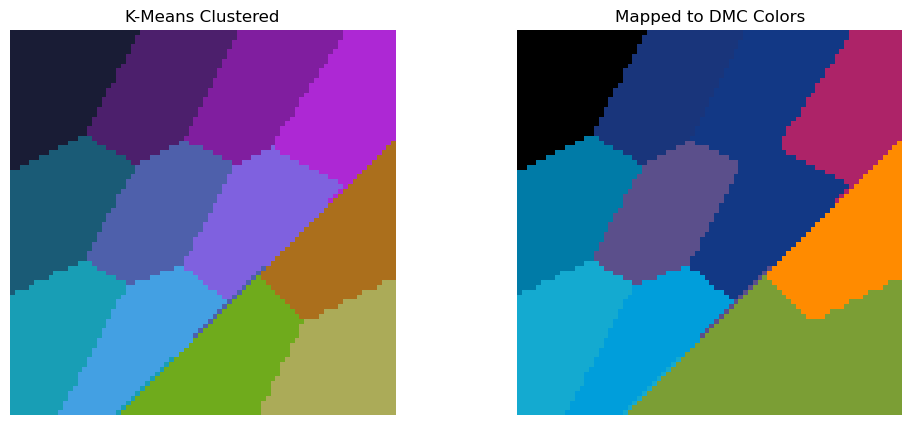


✅ Mapped to 12 DMC thread colors


In [7]:


dmc_mapping = {}
mapped_colors = []

print("\nColor Mapping:")
print("-" * 60)
for i, color in enumerate(centers):
    idx, code, name = find_closest_dmc(color)
    dmc_mapping[i] = (code, name, dmc_colors_rgb[idx])
    mapped_colors.append(dmc_colors_rgb[idx])
    print(f"Cluster {i}: RGB{tuple(color)} → DMC {code} ({name})")

# Create pattern with DMC colors
pattern_array = np.array(mapped_colors)[labels].reshape(img_array.shape)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(clustered_img)
plt.title("K-Means Clustered")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pattern_array)
plt.title("Mapped to DMC Colors")
plt.axis('off')
plt.show()

print(f"\n✅ Mapped to {len(dmc_mapping)} DMC thread colors")

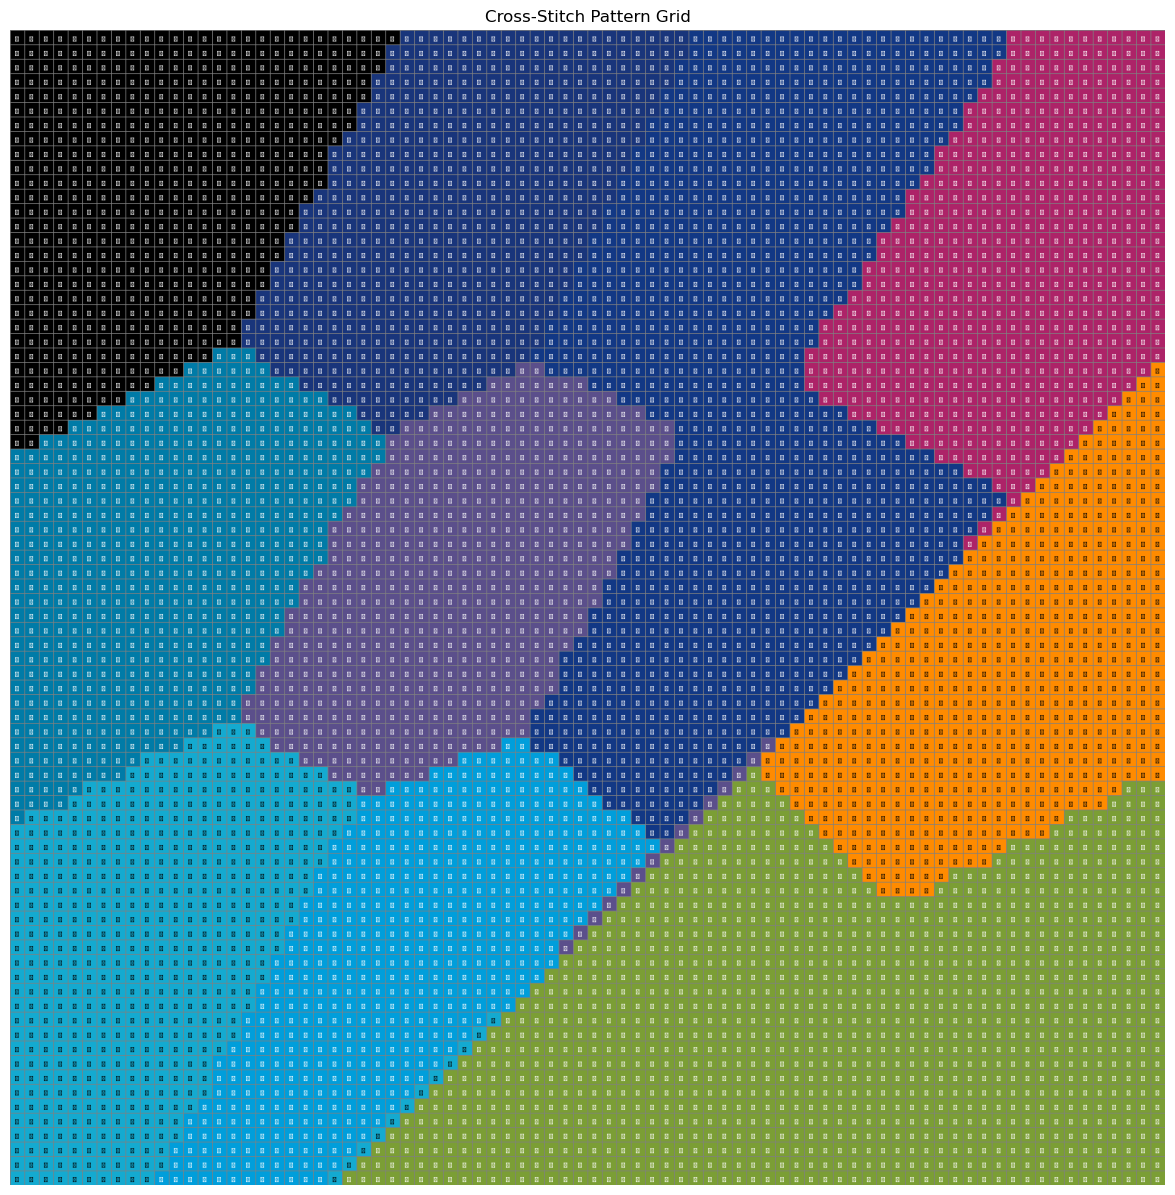

✅ Pattern grid generated!


In [9]:
CELL_SIZE = 20  # pixels per stitch
SYMBOLS = ['■', '●', '▲', '◆', '★', '▼', '◀', '▶', '♠', '♣', '♥', '♦']

# Create larger image for grid
grid_width = PATTERN_WIDTH * CELL_SIZE
grid_height = PATTERN_HEIGHT * CELL_SIZE
grid_img = Image.new('RGB', (grid_width, grid_height), 'white')
draw = ImageDraw.Draw(grid_img)

# Try to use a font (fall back to default if not available)
try:
    font = ImageFont.truetype("arial.ttf", 14)
except:
    font = ImageFont.load_default()

# Draw grid and symbols
pattern_labels = labels.reshape(PATTERN_HEIGHT, PATTERN_WIDTH)

for y in range(PATTERN_HEIGHT):
    for x in range(PATTERN_WIDTH):
        cluster_id = pattern_labels[y, x]
        color = tuple(mapped_colors[cluster_id])
        symbol = SYMBOLS[cluster_id % len(SYMBOLS)]
        
        # Draw cell background
        x1, y1 = x * CELL_SIZE, y * CELL_SIZE
        x2, y2 = (x + 1) * CELL_SIZE, (y + 1) * CELL_SIZE
        draw.rectangle([x1, y1, x2, y2], fill=color, outline='gray')
        
        # Draw symbol in center
        text_bbox = draw.textbbox((0, 0), symbol, font=font)
        text_w = text_bbox[2] - text_bbox[0]
        text_h = text_bbox[3] - text_bbox[1]
        text_x = x1 + (CELL_SIZE - text_w) // 2
        text_y = y1 + (CELL_SIZE - text_h) // 2
        
        # Use contrasting text color
        brightness = sum(color) / 3
        text_color = 'black' if brightness > 127 else 'white'
        draw.text((text_x, text_y), symbol, fill=text_color, font=font)

plt.figure(figsize=(15, 15))
plt.imshow(grid_img)
plt.title("Cross-Stitch Pattern Grid")
plt.axis('off')
plt.show()

print("✅ Pattern grid generated!")

In [10]:
stitch_counts = Counter(labels)

print("\n" + "="*70)
print("THREAD COLOR KEY")
print("="*70)
print(f"{'Symbol':<8} {'DMC Code':<10} {'Color Name':<25} {'Stitches':<10}")
print("-"*70)

for cluster_id, count in sorted(stitch_counts.items(), key=lambda x: x[1], reverse=True):
    code, name, _ = dmc_mapping[cluster_id]
    symbol = SYMBOLS[cluster_id % len(SYMBOLS)]
    print(f"{symbol:<8} {code:<10} {name:<25} {count:<10}")

print("="*70)
print(f"Total stitches: {sum(stitch_counts.values())}")
print(f"Total colors: {len(stitch_counts)}")

# %% [markdown]
# ## Step 10: Save Pattern

# %%
# Save the pattern grid
output_filename = "crossstitch_pattern.png"
grid_img.save(output_filename)
print(f"✅ Pattern saved as '{output_filename}'")

# Also save the color-mapped version
pattern_img = Image.fromarray(pattern_array.astype('uint8'))
pattern_img.save("crossstitch_colors.png")
print(f"✅ Color preview saved as 'crossstitch_colors.png'")


THREAD COLOR KEY
Symbol   DMC Code   Color Name                Stitches  
----------------------------------------------------------------------
▼        703        Chartreuse                556       
▶        703        Chartreuse                551       
■        740        Tangerine                 546       
◆        917        Plum MD                   541       
◀        995        Electric Blue DK          538       
★        791        Cornflower Blue VY DK     537       
♦        797        Royal Blue                533       
♥        797        Royal Blue                524       
♠        310        Black                     523       
●        3843       Electric Blue             523       
▲        820        Royal Blue VY DK          522       
♣        996        Electric Blue MD          506       
Total stitches: 6400
Total colors: 12
✅ Pattern saved as 'crossstitch_pattern.png'
✅ Color preview saved as 'crossstitch_colors.png'
